In [2]:
import tensorflow as tf
print("GPU:", tf.config.list_physical_devices('GPU'))


GPU: []


In [3]:
%pip install numpy pandas matplotlib scikit-learn seaborn tensorflow yfinance tqdm ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=af4b2d378ede630f125ef680af4090c3dad4089d7bf20f33d6439b22f556eef6
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [4]:
import yfinance as yf
df = yf.download("NVDA", start="2010-01-01", end="2024-12-31")
df.head()


/tmp/ipython-input-2327278934.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("NVDA", start="2010-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2010-01-04,0.423807,0.426786,0.415097,0.424265,800204000
2010-01-05,0.429995,0.434579,0.422202,0.422202,728648000
2010-01-06,0.432746,0.433663,0.425640,0.429766,649168000
2010-01-07,0.424265,0.432287,0.421056,0.430454,547792000
2010-01-08,0.425182,0.428162,0.418306,0.420827,478168000


In [5]:
df.tail

<bound method NDFrame.tail of Price            Close        High         Low        Open     Volume
Ticker            NVDA        NVDA        NVDA        NVDA       NVDA
Date                                                                 
2010-01-04    0.423807    0.426786    0.415097    0.424265  800204000
2010-01-05    0.429995    0.434579    0.422202    0.422202  728648000
2010-01-06    0.432746    0.433663    0.425640    0.429766  649168000
2010-01-07    0.424265    0.432287    0.421056    0.430454  547792000
2010-01-08    0.425182    0.428162    0.418306    0.420827  478168000
...                ...         ...         ...         ...        ...
2024-12-23  139.631790  139.751752  135.083032  136.242718  176053500
2024-12-24  140.181656  141.861189  138.612078  139.961715  105157000
2024-12-26  139.891724  140.811485  137.692328  139.661791  116205600
2024-12-27  136.972534  138.981994  134.673175  138.512122  170582600
2024-12-30  137.452393  140.231631  133.983341  134.793117  

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df = df[['Close']].rename(columns={'Close':'my_close'}).dropna()
df.index = pd.to_datetime(df.index)
#print(df.head())



In [8]:
print(df.columns)
print(df.head())


MultiIndex([('my_close', 'NVDA')],
           names=['Price', 'Ticker'])
Price       my_close
Ticker          NVDA
Date                
2010-01-04  0.423807
2010-01-05  0.429995
2010-01-06  0.432746
2010-01-07  0.424265
2010-01-08  0.425182


In [9]:
print(df.head())

Price       my_close
Ticker          NVDA
Date                
2010-01-04  0.423807
2010-01-05  0.429995
2010-01-06  0.432746
2010-01-07  0.424265
2010-01-08  0.425182


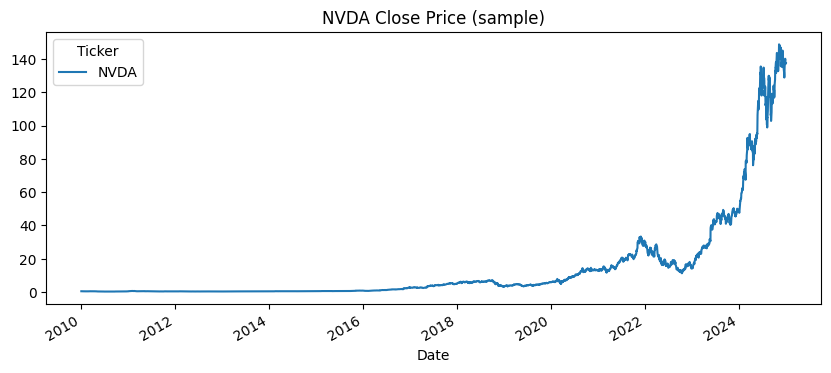

In [10]:
df['my_close'].plot(title='NVDA Close Price (sample)', figsize=(10,4))
plt.show()

Best input for LSTMs are Log Returns 

log_return = log(pricet/price(t-1))

price->log return

Price       my_close  logprice logreturn
Ticker          NVDA                    
Date                                    
2010-01-05  0.429995 -0.843981  0.014497
2010-01-06  0.432746 -0.837605  0.006376
2010-01-07  0.424265 -0.857397 -0.019792
2010-01-08  0.425182 -0.855238  0.002159
2010-01-11  0.419222 -0.869354 -0.014116


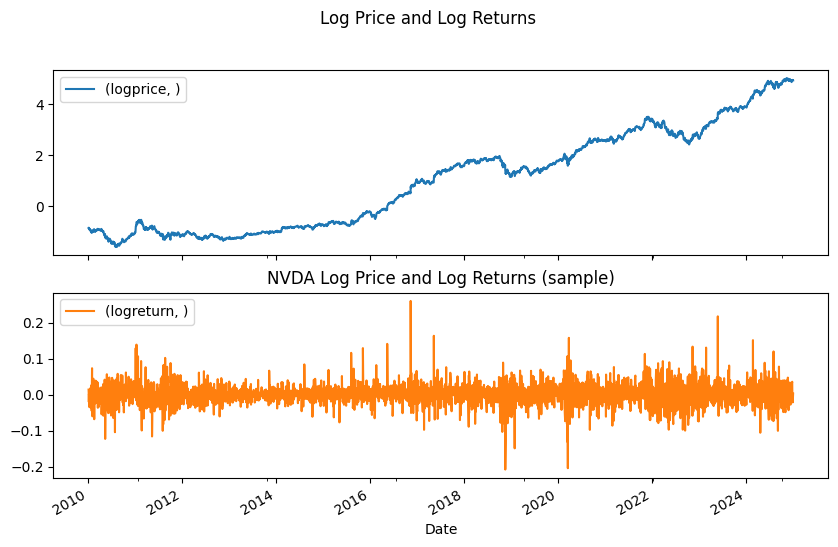

In [11]:
df['logprice'] = np.log(df['my_close'])
df['logreturn'] = df['logprice'].diff() #log returns
df = df.dropna()
print(df[['my_close','logprice','logreturn']].head())
df[['logprice','logreturn']].plot(subplots=True, figsize=(10,6), title='Log Price and Log Returns')
plt.title('NVDA Log Price and Log Returns (sample)')
plt.show()

SCALING


In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
series = df['logreturn'].values.reshape(-1,1)
series_scaled = scaler.fit_transform(series)
print(series_scaled[:5])

[[ 0.45617772]
 [ 0.1704409 ]
 [-0.75038877]
 [ 0.02202323]
 [-0.55064761]]


In [13]:
#creating supervised learning data structure since in LSTMs we need X(t-1) to predict y(t)
#past predicts future
#➤ Each training sample = a window of past values (lags)
#➤ Target = the next values we want to predict (horizon)

#lags = how many past time steps you give the model

#Example: lags = 30 → use the past 30 days of returns to predict the future.

#horizon = how many future steps you want to predict

#Example: horizon = 30 → predict the next 30 days of returns.

In [14]:
def create_supervised(x, lags, horizon):
    X, Y = [], []
    n = len(x)
    for i in range(lags, n - horizon + 1):
        X.append(x[i-lags:i])
        Y.append(x[i:i+horizon].flatten())
    X = np.array(X)
    Y = np.array(Y)
    X = X.reshape((X.shape[0], X.shape[1], 1))  # (samples, lags, 1)
    return X, Y

LAGS, HORIZON = 30, 30
X, Y = create_supervised(series_scaled.flatten(), LAGS, HORIZON)
print("X.shape, Y.shape:", X.shape, Y.shape)


X.shape, Y.shape: (3713, 30, 1) (3713, 30)


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_model(lags, horizon, units=16, dropout=0.1):
    m = Sequential([LSTM(units, input_shape=(lags,1)),
                    Dropout(dropout),
                    Dense(horizon)])
    m.compile(optimizer='adam', loss='mse')
    return m

# small train-test split (no shuffle)
split = int(len(X)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = Y[:split], Y[split:]

model = build_model(LAGS, HORIZON, units=16, dropout=0.1)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=3, batch_size=32)

Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.8974 - val_loss: 0.9247
Epoch 2/3
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.9001 - val_loss: 0.9249
Epoch 3/3
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.8685 - val_loss: 0.9250


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Predicted price path (first 5): [137.63970404 137.79046742 138.01033238 138.17925518 138.37903104]


Text(0.5, 1.0, 'Predicted NVDA Price Path (next 30 days)')

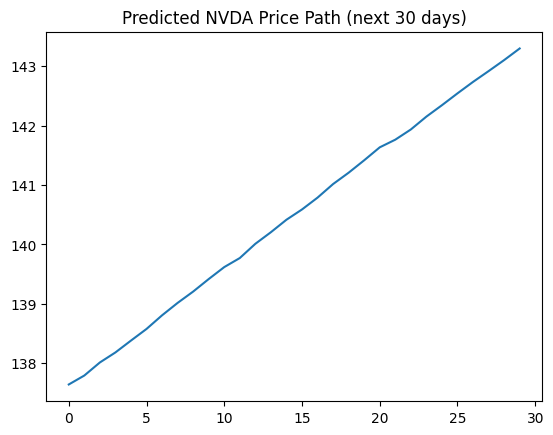

In [16]:
# predict using last sample

#return to price conversion
last_input = X_all = X  # use full X for indexing clarity
x_last = X_all[-1].reshape(1, LAGS, 1)
y_pred_scaled = model.predict(x_last).flatten()

# inverse scale
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
# build price path from last logprice
last_log = df['logprice'].iloc[-1]
logpath = np.cumsum(y_pred) + last_log
price_path = np.exp(logpath)
print("Predicted price path (first 5):", price_path[:5])
plt.plot(price_path)
plt.title('Predicted NVDA Price Path (next 30 days)')

In [17]:
#Backtest iteration
#test residual extraction logic for one window before scaling up.
# pick cut (index in supervised samples)
t_cut = split  # e.g., use previous split
X_bt = X[:t_cut]
Y_bt = Y[:t_cut]

# train small model quickly
bt_model = build_model(LAGS, HORIZON, units=8)
bt_model.fit(X_bt, Y_bt, epochs=5, batch_size=64, verbose=0)

# forecast from sample index forecast_idx
forecast_idx = t_cut - 1  # adjust carefully so you can access Y[forecast_idx]
X_input = X[forecast_idx].reshape(1,LAGS,1)
y_true = Y[forecast_idx]
y_pred_scaled = bt_model.predict(X_input).flatten()
# inverse scale both
y_true_orig = scaler.inverse_transform(y_true.reshape(-1,1)).flatten()
y_pred_orig = scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
resid = y_true_orig - y_pred_orig
print("resid shape", resid.shape)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
resid shape (30,)


In [18]:
#Expand to rolling backtest loop (collect residuals matrix)
#this produces residuals per horizon across many windows — core for dynamic intervals.

residuals_matrix = []

for i in range(len(X_bt)):
    X_input = X_bt[i].reshape(1, LAGS, 1)
    y_true = Y_bt[i]
    y_pred_scaled = bt_model.predict(X_input, verbose=0).flatten()
    y_true_orig = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_orig = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    resid = y_true_orig - y_pred_orig
    residuals_matrix.append(resid)

residuals_matrix = np.array(residuals_matrix)
print("residuals_matrix shape:", residuals_matrix.shape)


residuals_matrix shape: (2970, 30)


q_per_horizon: [0.04031522 0.04010785 0.04020483 0.04015191 0.04016503 0.04026127
 0.04038132 0.04023793 0.04049873 0.04027353 0.0403401  0.0405298
 0.04045089 0.04051837 0.0405089  0.0403307  0.04038158 0.04049067
 0.04045745 0.04043059 0.04037234 0.04057199 0.04048104 0.04044444
 0.04041519 0.04045809 0.04045651 0.04045444 0.0404865  0.04059547]
is non-decreasing-ish (diff >= -tiny_tol)? False


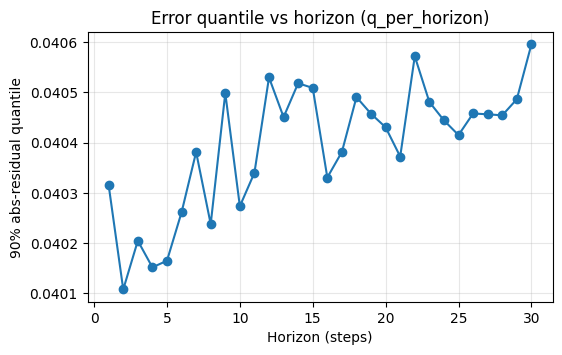

In [19]:
# --- Step 9: quantiles per horizon ---
# residuals_matrix: shape (n_windows, HORIZON)
abs_resid = np.abs(residuals_matrix)       # same shape (n_windows, HORIZON)
alpha = 0.10                               # 90% prediction intervals
q_per_horizon = np.quantile(abs_resid, 1 - alpha, axis=0)  # shape (HORIZON,)

print("q_per_horizon:", q_per_horizon)
print("is non-decreasing-ish (diff >= -tiny_tol)?",
      np.all(np.diff(q_per_horizon) >= -1e-12))  # small negative tolerances OK

# Quick plot: quantile vs horizon
plt.figure(figsize=(6,3.5))
plt.plot(np.arange(1, len(q_per_horizon)+1), q_per_horizon, marker='o')
plt.xlabel("Horizon (steps)")
plt.ylabel(f"{100*(1-alpha):.0f}% abs-residual quantile")
plt.title("Error quantile vs horizon (q_per_horizon)")
plt.grid(alpha=0.3)
plt.show()
